1. Q: Install Anaconda 3 and then use the pip to install the ISLP package. Make sure it is working by loading the Auto dataset as a pandas DataFrame. Look at CH2 notebook for some details.

In [48]:
# Install library.
# pip install ISLP

# Load libraries.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
Auto = load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


1. A: The output displays the first few rows/columns of the dataset, confirming the package is installed correctly and the dataset loads successfully.

2. Q: For each potential predictive column vector find the: (a) minimum value, (b) maximum value, (c) median value, (d) mean value, (e) standard deviation (f) number of unique values. Did you exclude any of the columns in the original DataFrame? If so why?

In [49]:
# Define response variable.
response_col = 'mpg'

# Define predictor variables.
predictors = Auto.drop(columns = [response_col], errors = 'ignore')

# Compute min, max, median, mean, standard deviation, and # of unique values.
rows = []
for col in predictors.columns:
    s = predictors[col]
    rows.append({
        'column': col,
        'min': s.min(),
        'max': s.max(),
        'median': s.median(),
        'mean': s.mean(),
        'std': s.std(ddof = 1),
        'n_unique': s.nunique(dropna = True)
    })

# Display.
summary = pd.DataFrame(rows).set_index('column')
del s, col, response_col, rows
summary

,min,max,median,mean,std,n_unique
column,,,,,,
cylinders,3.0,8.0,4.0,5.471939,1.705783,5
displacement,68.0,455.0,151.0,194.411990,104.644004,81
horsepower,46.0,230.0,93.5,104.469388,38.491160,93
weight,1613.0,5140.0,2803.5,2977.584184,849.402560,346
acceleration,8.0,24.8,15.5,15.541327,2.758864,95
year,70.0,82.0,76.0,75.979592,3.683737,13
origin,1.0,3.0,1.0,1.576531,0.805518,3


2. A: I excluded `mpg` because it is the response variable we want to predict, not a potential predictor (in most cases with the Auto data). Also, while `origin` is stored as numbers (1, 2, 3), it is not truly numeric; those values are category codes (e.g., American/European/Japanese), not measurements where “2 is twice 1” or where averaging makes meaningful sense. So statistics like the mean/standard deviation of `origin` aren’t really interpretable; in modeling, `origin` should be treated as a categorical factor (often via dummy/one-hot encoding) rather than a continuous numeric predictor. In this summary table I still computed numeric summaries for `origin` for consistency, but they should be interpreted cautiously since `origin` represents categories, not a quantitative variable.

3. Q: Which column vectors have a more interesting distribution? Hint: plot each column vector or consider the (f) calculation you did for each column. You should explain why you think it is more interesting in your own words.

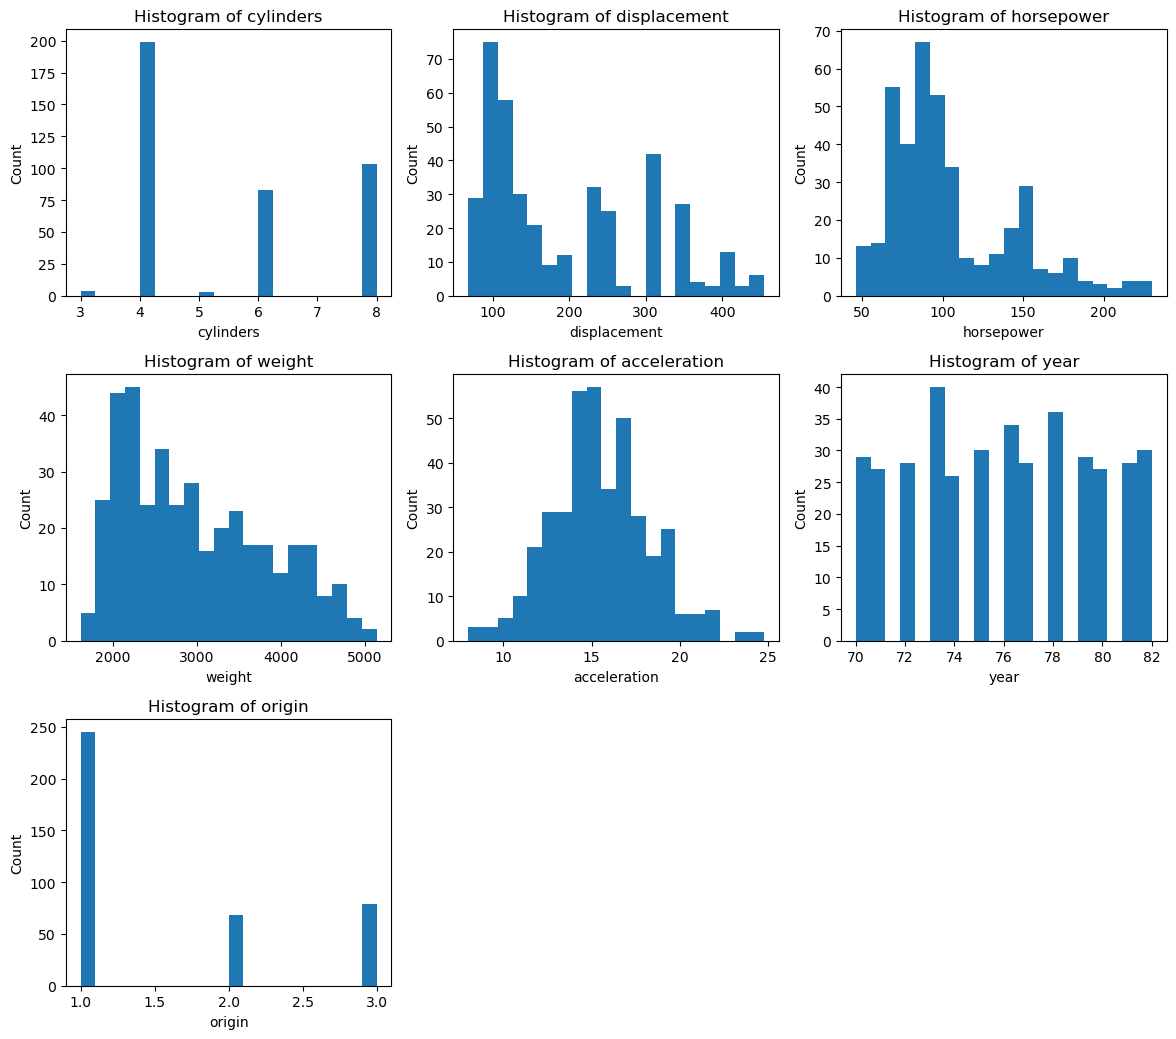

In [50]:
# Change figure sizes/axes.
n = predictors.shape[1]
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 3.5 * nrows))
axes = axes.ravel()

# Plot histograms for predictors.
for i, col in enumerate(predictors.columns):
    predictors[col].plot(kind = 'hist', bins = 20, ax = axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
del n, ncols, nrows, fig, axes, i, col, j

3. A: `cylinders` is interesting because it’s discrete and has big spikes (mostly 4, 6, and 8). That clustering suggests distinct groups of cars rather than a smooth continuum. `displacement`, `horsepower`, and `weight` are interesting because they’re right-skewed and look somewhat multi-modal (more than one “hump”), which likely reflects different types/eras of cars (e.g., smaller/lighter vs larger/heavier vehicles). As mentioned earlier, `origin` is interesting because it’s really a categorical code (1/2/3), so the histogram is basically showing group counts, and the groups are noticeably imbalanced. By contrast, `acceleration` looks more roughly bell-shaped, and `year` is mostly a set of discrete bars across 1970–1982 rather than a continuous distribution.

4. Q: Use the `numpy` correlation function to examine which of the potential predictor column vectors are most closely related in a linear manner. Hint: read about correlation and determine if a pair of potential predictor column vectors is close to -1 or 1 with the `corrcoef` function in `numpy`. When the result is close to 0 then the column vectors are not related in a linear manner.

In [51]:
# Compute correlation matrix.
X       = predictors.to_numpy()
corr    = np.corrcoef(X, rowvar = False)
corr_df = pd.DataFrame(corr, index = predictors.columns, columns = predictors.columns)

# Keep only the upper triangle (unique pairs) and drop the diagonal.
mask = np.triu(np.ones(corr_df.shape), k = 1).astype(bool)
top_pairs = (
    corr_df.where(mask)
    .stack()
    .abs()
    .sort_values(ascending = False)
    .head(10)
)
del X, corr, corr_df, mask
top_pairs

cylinders     displacement    0.950823
displacement  weight          0.932994
cylinders     weight          0.897527
displacement  horsepower      0.897257
horsepower    weight          0.864538
cylinders     horsepower      0.842983
horsepower    acceleration    0.689196
displacement  origin          0.614535
weight        origin          0.585005
cylinders     origin          0.568932
dtype: float64

4. A: The predictor columns that are most closely related in a linear way are the “size/power” variables. The strongest correlations are between `cylinders` and `displacement` (about 0.95) and between `displacement` and `weight` (about 0.93), followed by other strong positive relationships like `cylinders` with `weight` (about 0.90), `displacement` with `horsepower` (about 0.90), `horsepower` with `weight` (about 0.86), and `cylinders` with `horsepower` (about 0.84). Overall, this suggests that cars with more cylinders tend to be heavier, have larger engine displacement, and produce more horsepower, which is why these predictors show such strong linear associations.

5. Q: Based on the work you did in [4] can you select the best column vector that can predict `horsepower`? Hint: provide some evidence of a relationship that a column vector has with `horsepower`.

5. A: Based on my correlations from the previous question, the best single column vector to predict `horsepower` is `displacement`, because it has the strongest linear relationship with `horsepower` among the predictors (correlation ≈ 0.897, which is closest to 1). This means that as engine displacement increases, horsepower tends to increase in a fairly linear way. Although self-explanatory: as evidence, we see that `corr(displacement, horsepower) = 0.897`, which is larger (in absolute value) than the correlations between `horsepower` and other predictors like `weight` (= 0.865) or `cylinders` (= 0.843).